In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sqlite3
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score

Mounted at /content/drive


In [ ]:
def load_data(year, db_name, table_name):
    time_data = ['저장시간']
    env_data = ['내부온도', '외부온도', '풍향', '풍속', '일사량', '누적일사량', '감우']
    selected_columns = env_data + time_data
    column_str = ', '.join([f'"{col}"' for col in selected_columns])
    with sqlite3.connect(f'/content/drive/MyDrive/Tomato_db/{db_name}') as conn:
        query = f"SELECT {column_str} FROM '{year}'"
        df = pd.read_sql(query, conn)
    df = df.interpolate(method='linear', limit_direction='both')
    for i in range(1, len(df)):
      if abs(df.at[i, '내부온도'] - df.at[i-1, '내부온도']) >= 5: df.at[i, '내부온도'] = df.at[i-1, '내부온도']
    return df

iksan_data = {}
for year in range(2018, 2023):
    iksan_data[year] = load_data(year, 'Iksan.db', 'Iksan')

jeongeup_data = {}
for year in range(2018, 2023):
    jeongeup_data[year] = load_data(year, 'Jeongeup.db', 'Jeongeup')

sacheon_kang_data = {}
for year in range(2018, 2023):
    sacheon_kang_data[year] = load_data(year, 'Sacheon_Kang.db', 'Sacheon_Kang')

sacheon_kim_data = {}
for year in range(2020, 2023):
    sacheon_kim_data[year] = load_data(year, 'Sacheon_Kim.db', 'Sacheon_Kim')

<ipython-input-4-f2f24c6920ef>:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both')
<ipython-input-4-f2f24c6920ef>:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both')
<ipython-input-4-f2f24c6920ef>:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both')
<ipython-input-4-f2f24c6920ef>:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating 

In [ ]:
config = {
    "sequence_length": 5,
    "batch_size": 1024,
    "hidden_size": [1024],
    "fc_hidden_size": [12],
    "num_layers": [1],
    "dropout_rate": 0,
    "learning_rate": [0.0001],
    "num_epochs": [50],
    "early_stopping_patience": 1,
    "tol": 1e-4,
    "target_column": "내부온도",
    "feature_columns": ['내부온도', '외부온도', '풍향', '풍속', '일사량', '누적일사량', '감우']
}

hyperparams = {key: value for key, value in config.items() if isinstance(value, list) and key not in ["feature_columns", "target_column"]}
param_combinations = list(product(*hyperparams.values()))
param_keys = list(hyperparams.keys())
results = []


In [ ]:
print("생성된 하이퍼파라미터 조합:")
for combination in param_combinations:
    print(combination)

생성된 하이퍼파라미터 조합:
(1024, 12, 1, 0.0001, 50)


In [ ]:
def preprocess_data(df, scaler=None, fit_scaler=False):
    feature_columns = [col for col in config["feature_columns"]]
    if fit_scaler:
        scaler = MinMaxScaler().fit(df[feature_columns + [config["target_column"]]])
    scaled = scaler.transform(df[feature_columns + [config["target_column"]]])

    # 시퀀스 데이터 생성
    x = np.array([scaled[i-config["sequence_length"]:i, :len(feature_columns)]
                  for i in range(config["sequence_length"], len(scaled))])
    y = np.array([scaled[i, len(feature_columns):] for i in range(config["sequence_length"], len(scaled))])

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

def shuffle_preprocess_data(df, scaler=None, fit_scaler=False):
    feature_columns = [col for col in config["feature_columns"]]
    if fit_scaler:
        scaler = MinMaxScaler().fit(df[feature_columns + [config["target_column"]]])
    scaled = scaler.transform(df[feature_columns + [config["target_column"]]])

    # 시퀀스 데이터 생성
    x = np.array([scaled[i-config["sequence_length"]:i, :len(feature_columns)]
                  for i in range(config["sequence_length"], len(scaled))])
    y = np.array([scaled[i, len(feature_columns):] for i in range(config["sequence_length"], len(scaled))])

    #데이터를 섞어서 시간의 흐름을 뭉개기
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

# 모든 데이터를 DataFrame으로 변환하여 합치기
all_data = pd.concat( [df for year_data in [iksan_data, jeongeup_data, sacheon_kang_data, sacheon_kim_data] for df in year_data.values()],axis=0 )

# 스케일러 생성 및 피팅
scaler = MinMaxScaler()
scaler.fit(all_data[config["feature_columns"] + [config["target_column"]]])

# 훈련, 검증, 테스트 데이터 전처리
train_data = pd.concat( [df for year_data in [iksan_data, jeongeup_data, sacheon_kang_data] for df in year_data.values()],axis=0 )
x_train, y_train, _ = shuffle_preprocess_data(train_data, scaler, fit_scaler=False)

# 검증 데이터 생성
val_data = pd.concat( [df for year_data in [iksan_data, jeongeup_data, sacheon_kang_data] for df in year_data.values()],axis=0 )
x_val, y_val, _ = preprocess_data(val_data, scaler, fit_scaler=False)

# 테스트 데이터 생성
test_data = pd.concat( [df for year_data in [sacheon_kim_data] for df in year_data.values()], axis=0 )
x_test, y_test, _ = preprocess_data(test_data, scaler, fit_scaler=False)

# DataLoader 생성
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=config["batch_size"], shuffle=False)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=config["batch_size"], shuffle=False)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(all_data[['내부온도']])

MinMaxScaler()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate, fc_hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, fc_hidden_size),
            nn.ReLU(),
            nn.Linear(fc_hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [ ]:
import time

results = []

for param_values in param_combinations:
    for key, value in zip(param_keys, param_values):
        config[key] = value

    # 현재 하이퍼파라미터 출력
    print("\n현재 하이퍼파라미터")
    print(f"sequence_length: {config['sequence_length']}")
    print(f"hidden_size: {config['hidden_size']}")
    print(f"fc_hidden_size: {config['fc_hidden_size']}")
    print(f"num_layers: {config['num_layers']}")
    print(f"num_epochs: {config['num_epochs']}")
    print(f"learning_rate: {config['learning_rate']}")
    print(f"dropout_rate: {config['dropout_rate']}")

    # 시간 측정 시작
    start_time = time.time()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMModel(
        input_size=x_train.shape[2],
        hidden_size=config["hidden_size"],
        output_size=y_train.shape[1],
        num_layers=config["num_layers"],
        dropout_rate=config["dropout_rate"],
        fc_hidden_size=config["fc_hidden_size"]
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"])
    train_losses, val_losses, test_rmses, test_r2_scores = [], [], [], []

    for epoch in range(config["num_epochs"]):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # 검증 손실 계산
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                loss = criterion(model(inputs), targets)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        # 테스트 RMSE 및 R² 계산
        predictions, actuals = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                predictions.append(outputs.cpu().numpy())
                actuals.append(targets.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
        predictions_original = scaler.inverse_transform(predictions)
        actuals_original = scaler.inverse_transform(actuals)

        rmse = np.sqrt(mean_squared_error(actuals_original[:, 0], predictions_original[:, 0]))
        r2 = r2_score(actuals_original[:, 0], predictions_original[:, 0])  # R² 계산
        test_rmses.append(rmse)
        test_r2_scores.append(r2)

        # 결과 출력
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Train Loss: {train_losses[-1]:.8f}, "
              f"Val Loss: {val_losses[-1]:.8f}, Test RMSE: {rmse:.4f}, Test R²: {r2:.8f}")

    # 시간 측정 종료
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"소요 시간: {elapsed_time:.2f}초")

    # 최종 결과 저장
    results.append((config.copy(), min(test_rmses), max(test_r2_scores), elapsed_time))

# 최적의 하이퍼파라미터와 결과 출력
best_result = min(results, key=lambda x: x[1])
print("\n최적의 하이퍼파라미터 및 결과:")
for key, value in best_result[0].items():
    if key in param_keys:
        print(f"{key}: {value}")
print(f"최소 RMSE: {best_result[1]:.4f}")
print(f"최대 R²: {best_result[2]:.4f}")
print(f"소요 시간: {best_result[3]:.2f}초")



현재 하이퍼파라미터
sequence_length: 5
hidden_size: 1024
fc_hidden_size: 12
num_layers: 1
num_epochs: 50
learning_rate: 0.0001
dropout_rate: 0
Epoch 1/50, Train Loss: 0.00165207, Val Loss: 0.00001745, Test RMSE: 0.7222, Test R²: 0.99466848
Epoch 2/50, Train Loss: 0.00001822, Val Loss: 0.00001590, Test RMSE: 0.6700, Test R²: 0.99541056
Epoch 3/50, Train Loss: 0.00001668, Val Loss: 0.00001449, Test RMSE: 0.6605, Test R²: 0.99553955
Epoch 4/50, Train Loss: 0.00001501, Val Loss: 0.00001327, Test RMSE: 0.6767, Test R²: 0.99531901
Epoch 5/50, Train Loss: 0.00001284, Val Loss: 0.00001324, Test RMSE: 0.6847, Test R²: 0.99520779
Epoch 6/50, Train Loss: 0.00001030, Val Loss: 0.00000923, Test RMSE: 0.6162, Test R²: 0.99611849
Epoch 7/50, Train Loss: 0.00000846, Val Loss: 0.00000617, Test RMSE: 0.6478, Test R²: 0.99571043
Epoch 8/50, Train Loss: 0.00000753, Val Loss: 0.00000574, Test RMSE: 0.6442, Test R²: 0.99575782
Epoch 9/50, Train Loss: 0.00000694, Val Loss: 0.00000542, Test RMSE: 0.5994, Test R²: 0.9

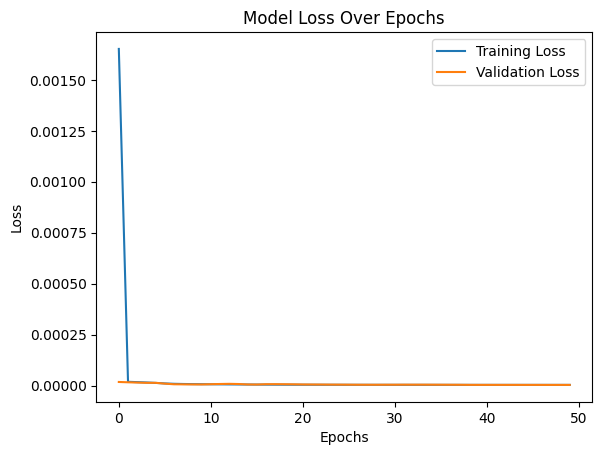

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

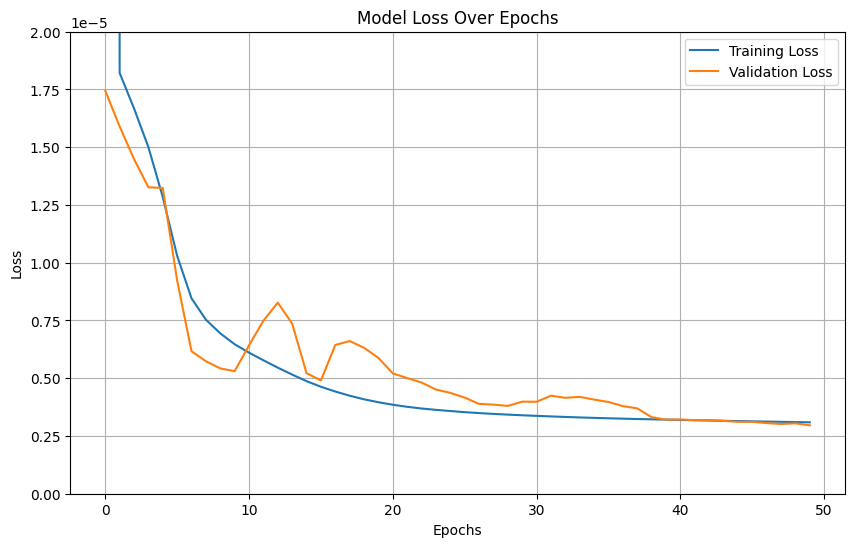

In [ ]:

plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# y축 범위를 0에서 0.0002로 제한
plt.ylim(0, 0.00002)

plt.grid(True)  # 그리드 추가
plt.show()
